# 1 Introduction



### 1.0.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 1.0.2 Data

In [2]:
players = pd.read_csv('data/processed/players_final.csv')
teams = pd.read_csv('data/processed/teams_final.csv')
teams.drop('Unnamed: 0', axis = 1, inplace = True)

## 1.1 [Webscraping](https://github.com/gcox32/NBA_Player_Value/tree/master/webscrape)

- The data was acquired via webscraping a few different websites using the BeautifulSoup package.
- Data was drawn across multiple websites and many different urls within each website. 
- Player data was a composite dataset of “per 100 possessions” stats, advanced stats, and shooting stats from basketball-reference.com, as well as salary stats from hoopshype.com.
- Team data was also a composite dataset of win-loss data and advanced statistics pulled from basketball-reference.com as well.

### 1.1.1 [pergame Webscrape](https://github.com/gcox32/NBA_Player_Value/blob/master/webscrape/1.1-per_game%20Webscrape.ipynb)

### 1.1.2 [per100 Webscrape](https://github.com/gcox32/NBA_Player_Value/blob/master/webscrape/1.2-per_100%20Webscrape.ipynb)

### 1.1.3 [shooting Webscrape](https://github.com/gcox32/NBA_Player_Value/blob/master/webscrape/1.3-shooting%20Webscrape.ipynb)

### 1.1.4 [salary data Webscrape](https://github.com/gcox32/NBA_Player_Value/blob/master/webscrape/1.4-salary%20Webscrape.ipynb)

### 1.1.5 [team data Webscrape](https://github.com/gcox32/NBA_Player_Value/blob/master/webscrape/1.5-team%20Webscrape.ipynb)

# 2 Data Wrangling and LDA

## 2.1 [Data Wrangling](https://github.com/gcox32/NBA_Player_Value/blob/master/2.0-Player-level%20Data%20Wrangling.ipynb)

- The bulk of the data wrangling needed for the player and team data was performed during the webscraping loops—each loop spit out list of pandas DataFrames that would ultimately be concatenated.
- After the webscraping, the majority of wrangling that remained for this data was simply structuring DataFrames such that they could be merged together using pandas merge.
- The data that needed the most cleaning was the salary data from hoopshype.com. For example, a datapoint we might read as"20000000” was actually written in the HTML as “\n\t\t\t20,000,000\t\t\t\n”—a very messy string.
    - This required me to identify the characters that needed to be dropped before changing the datatype to something we could manipulate (i.e. string to float/integer).

In [6]:
%%script false
# example of data cleaning from salary data webscrape

salaries = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]

step_two = [i[1] for i in salaries]

step_three = [i.replace('\n\n\t\t\t\t\t\t\t\t','') for i in step_two]
names = [i.replace('\t\t\t\t\t\t\t\n','') for i in step_three]

step_two = [i[2] for i in salaries]

step_three = [i.replace('\n\t\t\t\t\t\t\t$','') for i in step_two]
step_four = [i.replace('\t\t\t\t\t\t','') for i in step_three]
money = list(pd.to_numeric([i.replace(',','') for i in step_four]))

Couldn't find program: 'false'


- The data from basketball-reference.com was for the most part very clean, handling null values was an important component of this project. Depending on the feature, some data was filled using the population mean, and for some data, a null value in the wrong feature meant dropping the record entirely.

In [ ]:
%%script false
# example of handling nulls using feature mean

players1980 = pergame[pergame.Year == 1980]
players1979 = pergame[pergame.Year == 1979]
players1980.GS.isnull().sum(), players1979.GS.isnull().sum()

next3 = pergame[(pergame.Year >= 1981) & (pergame.Year < 1984)]
Gmean = np.mean(next3.G)
GSmean = np.mean(next3.GS)
ratio = GSmean/Gmean
print('ratio of Games Started to Games Played:',round(ratio,2))

pergame['GS'] = pergame.apply(
    lambda row: round(row['G'] * ratio,1) if np.isnan(row['GS']) and row['G'] < 60 else row['GS'],
    axis=1
)
pergame['GS'] = pergame['GS'].fillna(pergame['G'] - 5)

## 2.2 [Player-level LDA](https://github.com/gcox32/NBA_Player_Value/blob/master/2.1-Player-level%20LDA.ipynb)

One of our primary objectives was to accurately determine player value. In order to best do this, it was necessary to distinguish differences between players who are listed as similar. Our hypothesis was that there is a more robust method for describing a player’s position than just as one of five positions (point guard, shooting guard, small forward, power forward, or center).
<br><br>For example, compare the play styles of Ben Simmons and Steph Curry. Both are listed as Point Guards, but their contributions could not look more different. 
<br><br>In order to do this, we used our extensive player-level data (per 100 possessions stats, advanced stats, and shooting stats) to cluster players into 8 distinct positions that better described their contributions to the team.

In [ ]:
%%script false

# Dimensionality Reduction with PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance using PCA:",
      round(pca.explained_variance_ratio_.sum(), 3))

# cumulative explained variance using PCA was 0.46

In [ ]:
%%script false
# Dimentionality Reduction with LDA

LDA = LinearDiscriminantAnalysis(
    n_components=2, shrinkage='auto', solver='eigen')

LDA_reduced_df = LDA.fit(X_scaled, y).transform(X_scaled)

print("Mean accuracy on the given test data and labels with LDA:",
      LDA.score(X_scaled, y))

# Mean accuracy on the given test data and labels with LDA was 0.72

In [ ]:
%%script false
# kmeans clustering where n = 8

kmeans = cluster.KMeans(n_clusters = n, random_state = 23)
kmeans = kmeans.fit(LDA_reduced_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

centroid_x = [coord[0] for coord in centroids]
centroid_y = [coord[1] for coord in centroids]

intertia = kmeans.inertia_
sil_score = metrics.silhouette_score(LDA_reduced_df, kmeans.labels_, metric = 'euclidean')

data['cluster'] = labels
one = [value[0] for value in LDA_reduced_df]
two = [value[1] for value in LDA_reduced_df]
data['one'] = one
data['two'] = two

<img src="assets/LDA New Positions.png">

# 3 Exploratory Data Analysis and Inferential Statistics

### 3.0.1 [lib\](https://github.com/gcox32/NBA_Player_Value/tree/master/lib)

## 3.1 [Team-level EDA](https://github.com/gcox32/NBA_Player_Value/blob/master/3.1-Team-level%20EDA.ipynb)

- On the team-level, we wanted to identify success, so that required of us that we define our terms.
- “Success” for the scope of this project equated to making playoffs, or even better, making the playoffs with a good seeding (1st through 4th).

<img src="assets/playoffteams.png">

A simple logistic regression also displayed our win count goal:

<img src="assets/logregression_playoffs.png">

## 3.2 [Player Salary EDA](https://github.com/gcox32/NBA_Player_Value/blob/master/3.2-Salary%20EDA.ipynb)

As far as Exploratory Data Analysis goes on the player level, we really began to dive into the differences in compensation between clusters as well as differences in important features between clusters. This obviously led into our inferential statistics to test if differences were significant.

In [8]:
print('Correlates of salary:')

players.corr().loc[:,'salary'].sort_values(ascending = False)[:10]

Correlates of salary:


salary    1.000000
PER       0.454870
PTS       0.442607
FG        0.421706
USG%      0.412066
BPM       0.388022
VORP      0.387593
FGA       0.383824
WS        0.366596
OBPM      0.358624
Name: salary, dtype: float64

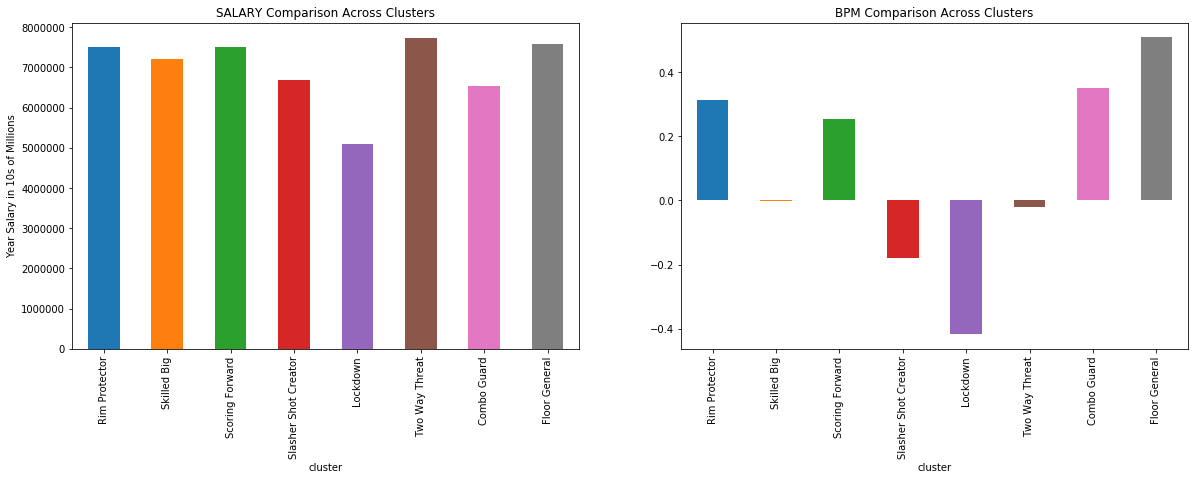

In [9]:
feature = 'salary'

feature2 = 'BPM'

plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))

plt.subplot(121)
players.groupby('cluster', sort = False).mean()[feature].plot(kind = 'bar')
plt.ylabel('Year Salary in 10s of Millions')
plt.title(feature.upper()+' Comparison Across Clusters')

plt.subplot(122)
players.groupby('cluster', sort = False).mean()[feature2].plot(kind = 'bar')
plt.title(feature2.upper()+' Comparison Across Clusters')
plt.show()

<img src="assets/clustersalaries.png">

## 3.3 [Inferential Statistics](https://github.com/gcox32/NBA_Player_Value/blob/master/3.3-Inferential%20Statistics.ipynb)

With our team-level inferential statistics, two sample t-tests of independence showed us that money doesn't buy wins--at least not at a statistically significant level. The differences in mean Win count for teams paying over 120% of the salary cap for any given year, and teams paying under 120% of the salary cap for any given year varied greatly--44 and 38, respectively. 

- However, when we sampled from these groups and ran a few t-tests (read: ten thousand t-tests), we saw that that this difference was not in fact significant at even a 0.10 confidence. The resultant p-values were plotted in the histogram (bottom).


In [ ]:
%%script false

# demonstration of conducting 10,000 t-tests for independence

teams_T_list = []
teams_p_list = []
for i in tqdm(range(10000)):
    over_samp = sample(list(over.W), 30)
    under_samp = sample(list(under.W), 30)
    T, p = stats.ttest_ind(over_samp,
                           under_samp,
                           equal_var=False)
    teams_T_list.append(T)
    teams_p_list.append(p)

We also scanned for statistically significant differences in 6 different features across 8 subsets of the data, using 10,000 t-tests each time (48,000 in total) in about 2.5 minutes.
From this scan, we learned the following:
- the "Lockdown" cluster was flagged for statistically lower mean Player Efficiency Rating (PER)
- "Rim Protectors" were flagged for having statistically lower mean Usage Rate (USG%)
- "Combo Guards" were conversely flagged for statistically higher mean Usage Rate
- "Rim Protectors" were the only cluster with a significant difference (lower) in Points Scored (PTS)

In [ ]:
%%script false

# demonstration of using power of for loops to conduct 10,000 one sample t-tests 
# across 8 samples and 6 features for a total of 48,000 loops

clusterlist = players.cluster.unique()
value_stats = ['PER', 'WS', 'BPM', 'VORP', 'USG%', 'PTS']
confidence = 0.05 * 2

for h in value_stats:
    
    pop_mean = np.mean(players[h])

    for i in tqdm(clusterlist):

        players_T_list = []
        players_p_list = []
        cluster = list(players[players.cluster == i][h])

        for j in range(10000):

            cluster_samp = sample(cluster, 30)
            T, p = stats.ttest_1samp(cluster_samp, pop_mean)
            players_T_list.append(T)
            players_p_list.append(p)

        T = np.mean(players_T_list)
        p = np.mean(players_p_list)

        if p <= confidence:
            print('Cluster: {};\tValue Stat: {}'.format(i, h))
            print('Sample mean {}:'.format(h), round(np.mean(cluster_samp),
                                                     2), 'Population mean {}:'.format(h), round(pop_mean, 2))
            print('Test statistic (T):', round(T, 2), 'p-value:', round(p, 3))
            print('Reject the null. Significant difference in mean {} between population and the {} cluster.'.format(h, i))
            if T < 0:
                print('For the {} cluster, mean {} is lower than the league average.'.format(i, h))
            else:
                print('For the {} cluster, mean {} is above the league average.'.format(i, h))


# 4 Conclusions and Next Steps

1. Certain clusters are probably more valuable than others, objectively, meaning our LDA and clustering was at least worth it in that regard.
2. Inferential statistics showed us that, at least at the 120% of the salary cap mark, spending more doesn’t result in significantly more wins than spending less.
3. Making recommendations will greatly on a deep understanding of our features; a few factors have emerged that are slowing us down:
    - Early regression analysis has proven fruitless—salary is not simple to predict based purely on the composite of many features.
    - There is not a consistent value system currently in place from team to team, and certainly not from year to year.